# Project Description:

Data science isn't just for predicting ad-clicks-it's also useful for social impact! This course is a case study from a machine learning competition on DrivenData. We'll explore a problem related to school district budgeting. By building a model to automatically classify items in a school's budget, it makes it easier and faster for schools to compare their spending with other schools. In this course, we'll begin by building a baseline model that is a simple, first-pass approach. In particular, we'll do some natural language processing to prepare the budgets for modeling. Next, we'll have the opportunity to try our own techniques and see how they compare to participants from the competition. Finally, we'll see how the winner was able to combine a number of expert techniques to build the most accurate model.

### What type of machine learning problem is this?
- Supervised Learning, because the model will be trained using labeled examples.

### What is the goal of the algorithm? 
#### (The goal is to correctly label budget line items by training a supervised model to predict the probability of each possible label, taking most probable label as the correct label.)

- Classification, because predicted probabilities will be used to select a label class. Specifically, we have ourselves a multi-class-multi-label classification problem, because there are 9 broad categories that each take on many possible sub-label instances.

# Importing Librabies

In [94]:
from urllib.request import urlretrieve

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import processing libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import chi2, SelectKBest

# Import functional utilities
from sklearn.preprocessing import FunctionTransformer, MaxAbsScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

from sklearn.pipeline import Pipeline

# Data Loading
#### https://blog.csdn.net/u011292816/article/details/97391579
#### https://blog.csdn.net/u011292816/article/details/97865973

In [95]:
fn = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_2533/datasets/TrainingSetSample.csv'
urlretrieve(fn, 'TrainingData.csv')

('TrainingData.csv', <http.client.HTTPMessage at 0x17f80b8b608>)

In [96]:
df = pd.read_csv('TrainingData.csv', index_col=0)
df.to_csv('TrainingData.csv') 

# Exploring the raw data

In [97]:
display(df)

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,...,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
198,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplemental *,...,Non-Certificated Salaries And Wages,NaN,NaN,Care and Upkeep of Building Services,NaN,NaN,-8291.86000,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I CARRYOVER
209,Student Transportation,NO_LABEL,Shared Services,Non-School,NO_LABEL,NO_LABEL,Other Non-Compensation,NO_LABEL,PreK-12 Operating,REPAIR AND MAINTENANCE SERVICES,...,NaN,ADMIN. SERVICES,NaN,STUDENT TRANSPORT SERVICE,NaN,NaN,618.29000,PUPIL TRANSPORTATION,General Fund,NaN
750,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,...,NaN,NaN,1.0,NaN,NaN,TEACHER,49768.82000,Instruction - Regular,General Purpose School,NaN
931,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,General Supplies,...,General Supplies,NaN,NaN,Instruction,Instruction And Curriculum,NaN,-1.02000,"""Title I, Part A Schoolwide Activities Related...",General Operating Fund,NaN
1524,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplies and Materials,...,Supplies And Materials,NaN,NaN,Other Community Services *,NaN,NaN,2304.43000,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I PI+HOMELESS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344986,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,...,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,27.04000,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION
384803,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,EMPLOYEE BENEFITS,...,NaN,PERSONNEL-PAID LEAVE,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,NaN,STAFF SERVICES,NaN,CENTRAL
224382,Substitute Compensation,Instruction,School Reported,School,Special Education,Substitute,Substitute Compensation,NO_LABEL,PreK-12 Operating,OTHER PERSONAL SERVICES,...,NaN,School,0.0,EXCEPTIONAL,NaN,NaN,200.39000,NaN,GENERAL FUND,NaN
305347,Facilities & Maintenance,O&M,Leadership & Management,Non-School,Gifted,Custodian,Other Compensation/Stipend,Non PreK,PreK-12 Operating,Extra Duty Pay/Overtime For Support Personnel,...,Extra Duty Pay/Overtime For Support Personnel,Unallocated,NaN,Facilities Maintenance And Operations,Gifted And Talented,ANY CUS WHO IS NOT A SUPER,5.29000,Gifted And Talented,General Operating Fund,ADDL REGULAR PAY-NOT SMOOTHED


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1560 entries, 198 to 101861
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Function                1560 non-null   object 
 1   Use                     1560 non-null   object 
 2   Sharing                 1560 non-null   object 
 3   Reporting               1560 non-null   object 
 4   Student_Type            1560 non-null   object 
 5   Position_Type           1560 non-null   object 
 6   Object_Type             1560 non-null   object 
 7   Pre_K                   1560 non-null   object 
 8   Operating_Status        1560 non-null   object 
 9   Object_Description      1461 non-null   object 
 10  Text_2                  382 non-null    object 
 11  SubFund_Description     1183 non-null   object 
 12  Job_Title_Description   1131 non-null   object 
 13  Text_3                  296 non-null    object 
 14  Text_4                  193 non-null

### Summarizing the data
There are two numeric columns, called FTE and Total.

- FTE: Stands for "full-time equivalent". If the budget item is associated to an employee, this number tells us the percentage of full-time that the employee works. A value of 1 means the associated employee works for the school full-time. A value close to 0 means the item is associated to a part-time or contracted employee.


- Total: Stands for the total cost of the expenditure. This number tells us how much the budget item cost.

Now job is to plot a histogram of the non-null FTE column to see the distribution of part-time and full-time employees in the dataset.

FTE         Total
count  449.000000  1.542000e+03
mean     0.493532  1.446867e+04
std      0.452844  7.916752e+04
min     -0.002369 -1.044084e+06
25%      0.004310  1.108111e+02
50%      0.440000  7.060299e+02
75%      1.000000  5.347760e+03
max      1.047222  1.367500e+06


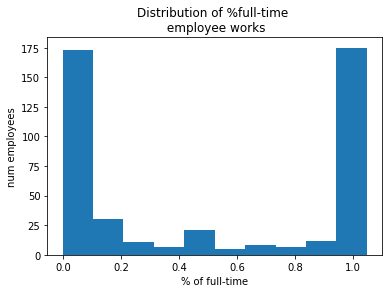

In [99]:
# Print the summary statistics
print(df.describe())

# Create the histogram
plt.hist(df['FTE'].dropna())

# Add title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')

# Display the histogram
plt.show()

#### The high variance in expenditures makes sense (some purchases are cheap some are expensive). Also, it looks like the FTE column is bimodal. That is, there are some part-time and some full-time employees.

### Exploring datatypes in pandas

It's always good to know what datatypes we're working with, especially when the inefficient pandas type object may be involved. Towards that end, let's explore what we have.
- look at the DataFrame attribute 
- call df.dtypes.value_counts(), and not df.value_counts()! Check out the difference in the Shell. df.value_counts() will return an error, because it is a Series method, not a DataFrame method.

In [100]:
df.dtypes.value_counts()

object     23
float64     2
dtype: int64

### Encode the labels as categorical variables
The ultimate goal is to predict the probability that a certain label is attached to a budget line item. we just saw that many columns in the data are the inefficient object type. Does this include the labels we're trying to predict? Let's find out!

There are 9 columns of labels in the dataset. Each of these columns is a category that has many possible values it can take. The 9 labels have been loaded into a list called LABELS. 

Every label is encoded as an object datatype. Because category datatypes are much more efficient our task is to convert the labels to category types using the .astype() method.

Note: .astype() only works on a pandas Series. Since we are working with a pandas DataFrame, we'll need to use the .apply() method and provide a lambda function called categorize_label that applies .astype() to each column, x.

In [101]:
LABELS = ["Function", "Use", "Sharing", "Reporting", "Student_Type", "Position_Type", "Object_Type", "Pre_K", "Operating_Status" ]
df[LABELS].head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status
198,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
209,Student Transportation,NO_LABEL,Shared Services,Non-School,NO_LABEL,NO_LABEL,Other Non-Compensation,NO_LABEL,PreK-12 Operating
750,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating
931,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating
1524,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating


In [102]:
df[LABELS].dtypes

Function            object
Use                 object
Sharing             object
Reporting           object
Student_Type        object
Position_Type       object
Object_Type         object
Pre_K               object
Operating_Status    object
dtype: object

In [103]:
# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label)

# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


### Counting unique labels
There are over 100 unique labels. Now, we will explore this fact by counting and plotting the number of unique values for each category of label.

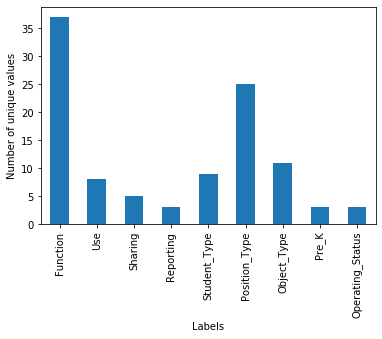

In [104]:
# Calculate number of unique values for each label: num_unique_labels
num_unique_labels = df[LABELS].apply(pd.Series.nunique)

# Plot number of unique values for each label
num_unique_labels.plot(kind='bar')

# Label the axes
plt.xlabel('Labels')
plt.ylabel('Number of unique values')

# Display the plot
plt.show()

### Computing log loss with NumPy

In [105]:
# Define LogLoss function, account for clipping

def compute_log_loss(predicted, actual, eps=1e-14):    
    predicted = np.clip(predicted, eps, 1 - eps)

    loss = -1 * np.mean(actual * np.log(predicted) + (1 - actual) * np.log(1 - predicted))

    return loss

In [106]:
# DataDriven provided function

from warnings import warn

def multilabel_sample(y, size=1000, min_count=5, seed=None):
    """ Takes a matrix of binary labels `y` and returns
        the indices for a sample of size `size` if
        `size` > 1 or `size` * len(y) if size =< 1.
        The sample is guaranteed to have > `min_count` of
        each label.
    """
    try:
        if (np.unique(y).astype(int) != np.array([0, 1])).any():
            raise ValueError()
    except (TypeError, ValueError):
        raise ValueError('multilabel_sample only works with binary indicator matrices')

    if (y.sum(axis=0) < min_count).any():
        raise ValueError('Some classes do not have enough examples. Change min_count if necessary.')

    if size <= 1:
        size = np.floor(y.shape[0] * size)

    if y.shape[1] * min_count > size:
        msg = "Size less than number of columns * min_count, returning {} items instead of {}."
        warn(msg.format(y.shape[1] * min_count, size))
        size = y.shape[1] * min_count

    rng = np.random.RandomState(seed if seed is not None else np.random.randint(1))

    if isinstance(y, pd.DataFrame):
        choices = y.index
        y = y.values
    else:
        choices = np.arange(y.shape[0])

    sample_idxs = np.array([], dtype=choices.dtype)

    # first, guarantee > min_count of each label
    for j in range(y.shape[1]):
        label_choices = choices[y[:, j] == 1]
        label_idxs_sampled = rng.choice(label_choices, size=min_count, replace=False)
        sample_idxs = np.concatenate([label_idxs_sampled, sample_idxs])

    sample_idxs = np.unique(sample_idxs)

    # now that we have at least min_count of each, we can just random sample
    sample_count = int(size - sample_idxs.shape[0])

    # get sample_count indices from remaining choices
    remaining_choices = np.setdiff1d(choices, sample_idxs)
    remaining_sampled = rng.choice(remaining_choices,
                                   size=sample_count,
                                   replace=False)

    return np.concatenate([sample_idxs, remaining_sampled])


def multilabel_sample_dataframe(df, labels, size, min_count=5, seed=None):
    """ Takes a dataframe `df` and returns a sample of size `size` where all
        classes in the binary matrix `labels` are represented at
        least `min_count` times.
    """
    idxs = multilabel_sample(labels, size=size, min_count=min_count, seed=seed)
    return df.loc[idxs]


def multilabel_train_test_split(X, Y, size, min_count=5, seed=None):
    """ Takes a features matrix `X` and a label matrix `Y` and
        returns (X_train, X_test, Y_train, Y_test) where all
        classes in Y are represented at least `min_count` times.
    """
    index = Y.index if isinstance(Y, pd.DataFrame) else np.arange(Y.shape[0])

    test_set_idxs = multilabel_sample(Y, size=size, min_count=min_count, seed=seed)
    train_set_idxs = np.setdiff1d(index, test_set_idxs)

    test_set_mask = index.isin(test_set_idxs)
    train_set_mask = ~test_set_mask

    return (X[train_set_mask], X[test_set_mask], Y[train_set_mask], Y[test_set_mask])

In [107]:
NUMERIC_COLUMNS = ['FTE', 'Total']
# Create the new DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,label_dummies,size=0.2,seed=123)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 198 to 101861
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     1040 non-null   float64
 1   Total   1040 non-null   float64
dtypes: float64(2)
memory usage: 24.4 KB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 209 to 448628
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     520 non-null    float64
 1   Total   520 non-null    float64
dtypes: float64(2)
memory usage: 12.2 KB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 198 to 101861
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: uint8(104)
memory usage: 113.8 KB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 520 entries, 209 to 448628
Columns: 104 entries, Function_Aides Compensat

### Training a model
We will import the logistic regression and one versus rest classifiers in order to fit a multi-class logistic regression model to the NUMERIC_COLUMNS of our feature data.

Then we'll test and print the accuracy with the .score() method to see the results of training.

We're ultimately going to be using logloss to score our model, so don't worry too much about the accuracy here. Keep in mind that we're throwing away all of the text data in the dataset - that's by far most of the data! So don't get hopes up for a killer performance just yet. We're just interested in getting things up and running at the moment.

In [108]:
# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

Accuracy: 0.0


#### The good news is that our workflow didn't cause any errors. The bad news is that our model scored the lowest possible accuracy: 0.0! But hey, we just threw away ALL of the text data in the budget. Later, we won't. Before we add the text data, let's see how the model does when scored by log loss.

### Use the model to predict values on holdout data
We're ready to make some predictions! Remember, the train-test-split we've carried out so far is for model development. The original competition provides an additional test set, for which we'll never actually see the correct labels. This is called the "holdout data."

The point of the holdout data is to provide a fair test for machine learning competitions. If the labels aren't known by anyone but DataCamp, DrivenData, or whoever is hosting the competition, we can be sure that no one submits a mere copy of labels to artificially pump up the performance on their model.

Remember that the original goal is to predict the probability of each label. Now, we'll do just that by using the .predict_proba() method on our trained model.

First, however, we'll need to load the holdout data, which is available in the workspace as the file HoldoutData.csv.

In [109]:
# https://blog.csdn.net/u011292816/article/details/97444251

# Load path to holdout

PATH_TO_HOLDOUT_DATA = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_2826/datasets/TestSetSample.csv'
PATH_TO_HOLDOUT_LABELS = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_2826/datasets/TestSetLabelsSample.csv'
fn = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_2826/datasets/TestSetSample.csv'
urlretrieve(fn, 'HoldoutData.csv')

('HoldoutData.csv', <http.client.HTTPMessage at 0x17f80a464c8>)

In [110]:
# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression(solver='liblinear'))

# Fit it to the training data
clf.fit(X_train, y_train)

# Load the holdout data: holdout
holdout = pd.read_csv('HoldoutData.csv',index_col=0)
holdout.to_csv("HoldoutData.csv")
print(holdout.info())

# Generate predictions: predictions
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS].fillna(-1000))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 237 to 142060
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Object_Description      1918 non-null   object 
 1   Program_Description     1798 non-null   object 
 2   SubFund_Description     664 non-null    object 
 3   Job_Title_Description   1303 non-null   object 
 4   Facility_or_Department  133 non-null    object 
 5   Sub_Object_Description  1317 non-null   object 
 6   Location_Description    1515 non-null   object 
 7   FTE                     782 non-null    float64
 8   Function_Description    1851 non-null   object 
 9   Position_Extra          594 non-null    object 
 10  Text_4                  137 non-null    object 
 11  Total                   1974 non-null   float64
 12  Text_2                  198 non-null    object 
 13  Text_3                  216 non-null    object 
 14  Fund_Description        1559 non-nul

### Writing out our results to a csv for submission
At last, we're ready to submit some predictions for scoring. Now, we'll write our predictions to a .csv using the .to_csv() method on a pandas DataFrame. Then we'll evaluate our performance according to the LogLoss metric!

We'll need to make sure our submission obeys the correct format (https://www.drivendata.org/competitions/4/page/15/#sub_values).

To do this, we'll use our predictions values to create a new DataFrame, prediction_df.

Interpreting LogLoss & Beating the Benchmark:

When interpreting log loss score, keep in mind that the score will change based on the number of samples tested. To get a sense of how this very basic model performs, compare our score to the DrivenData benchmark model performance: 2.0455, which merely submitted uniform probabilities for each class.

Remember, the lower the log loss the better. 

Is our model's log loss lower than 2.0455?

In [111]:
# DataDriven provided function

# Load path to pred
PATH_TO_PREDICTIONS = "predictions.csv"
# Load path to holdout
PATH_TO_HOLDOUT_DATA = "https://s3.amazonaws.com/assets.datacamp.com/production/course_2826/datasets/TestSetSample.csv"
PATH_TO_HOLDOUT_LABELS = "https://s3.amazonaws.com/assets.datacamp.com/production/course_2826/datasets/TestSetLabelsSample.csv"

# SCORING UTILITIES

BOX_PLOTS_COLUMN_INDICES = [range(37),
 range(37,48),
 range(48,51),
 range(51,76),
 range(76,79),
 range(79,82),
 range(82,87),
 range(87,96),
 range(96,104)]

def _multi_multi_log_loss(predicted,
    actual,
    class_column_indices=BOX_PLOTS_COLUMN_INDICES,
    eps=1e-15):

    class_scores = np.ones(len(class_column_indices), dtype=np.float64)

    # calculate log loss for each set of columns that belong to a class:
    for k, this_class_indices in enumerate(class_column_indices):
        # get just the columns for this class
        preds_k = predicted[:, this_class_indices].astype(np.float64)

        # normalize so probabilities sum to one (unless sum is zero, then we clip)
        preds_k /= np.clip(preds_k.sum(axis=1).reshape(-1, 1), eps, np.inf)

        actual_k = actual[:, this_class_indices]

        # shrink predictions so
        y_hats = np.clip(preds_k, eps, 1 - eps)
        sum_logs = np.sum(actual_k * np.log(y_hats))
        class_scores[k] = (-1.0 / actual.shape[0]) * sum_logs

        return np.average(class_scores)


def score_submission(pred_path=PATH_TO_PREDICTIONS, holdout_path=PATH_TO_HOLDOUT_LABELS):
    # this happens on the backend to get the score
    holdout_labels = pd.get_dummies(
    pd.read_csv(holdout_path, index_col=0)
    .apply(lambda x: x.astype('category'), axis=0)
    )

    preds = pd.read_csv(pred_path, index_col=0)

    # make sure that format is correct
    assert (preds.columns == holdout_labels.columns).all()
    assert (preds.index == holdout_labels.index).all()

    return _multi_multi_log_loss(preds.values, holdout_labels.values)


In [112]:
# Format predictions in DataFrame: prediction_df
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS]).columns,
                             index=holdout.index,
                             data=predictions)

# Save prediction_df to csv
prediction_df.to_csv("predictions.csv")

# Submit the predictions for scoring: score
score = score_submission(pred_path="predictions.csv")

# Print score
print('Our model, trained with numeric data only, yields logloss score: {}'.format(score))

Our model, trained with numeric data only, yields logloss score: 1.2355989666684484


#### Even though our basic model scored 0.0 accuracy, it nevertheless performs better than the benchmark score of 2.0455. We've now got the basics down and have made a first pass at this complicated supervised learning problem. It's time to step up our game and incorporate the text data.

### Creating a bag-of-words in scikit-learn
Now, we'll study the effects of tokenizing in different ways by comparing the bag-of-words representations resulting from different token patterns.

We will focus on one feature only, the Position_Extra column, which describes any additional information not captured by the Position_Type label.

For example, we can check out the budget item in row 8960 of the data using df.loc[8960]. Looking at the output reveals that this Object_Description is overtime pay. For who? The Position Type is merely "other", but the Position Extra elaborates: "BUS DRIVER". Explore the column further to see more instances. It has a lot of NaN values.

The task is to turn the raw text in this column into a bag-of-words representation by creating tokens that contain only alphanumeric characters.

For comparison purposes, the first 15 tokens of vec_basic, which splits df.Position_Extra into tokens when it encounters only whitespace characters, have been printed along with the length of the representation.

In [113]:
# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Fill missing values in df.Position_Extra
df.Position_Extra.fillna('', inplace = True) #argument inplace=True so that you don't have to assign the result back to df.

# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC)

# Fit to the data
vec_alphanumeric.fit(df.Position_Extra)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names())))
print(vec_alphanumeric.get_feature_names()[:15])

There are 123 tokens in Position_Extra if we split on non-alpha numeric
['1st', '2nd', '3rd', 'a', 'ab', 'additional', 'adm', 'administrative', 'and', 'any', 'art', 'assessment', 'assistant', 'asst', 'athletic']


####  Treating only alpha-numeric characters as tokens gives us a smaller number of more meaningful tokens. 

### Combining text columns for tokenization
In order to get a bag-of-words representation for all of the text data in our DataFrame, we must first convert the text data in each row of the DataFrame into a single string.

In the previous exercise, this wasn't necessary because we only looked at one column of data, so each row was already just a single string. CountVectorizer expects each row to just be a single string, so in order to use all of the text columns, we'll need a method to turn a list of strings into a single string.

In this exercise, we'll complete the function definition combine_text_columns(). When completed, this function will convert all training text data in our DataFrame to a single string per row that can be passed to the vectorizer object and made into a bag-of-words using the .fit_transform() method.

Note that the function uses NUMERIC_COLUMNS and LABELS to determine which columns to drop.

In [114]:
# Define combine_text_columns()
def combine_text_columns(data_frame, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis = 1)
    
    # Replace nans with blanks
    text_data.fillna("", inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

### What's in a token?
Now we will use combine_text_columns to convert all training text data in our DataFrame to a single vector that can be passed to the vectorizer object and made into a bag-of-words using the .fit_transform() method.

We'll compare the effect of tokenizing using any non-whitespace characters as a token and using only alphanumeric characters as a token.

In [115]:
# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern = TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern = TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names())))

There are 1404 tokens in the dataset
There are 1117 alpha-numeric tokens in the dataset


#### Notice that tokenizing on alpha-numeric tokens reduced the number of tokens, just as in the last exercise. We'll keep this in mind when building a better model with the Pipeline object next.

### Instantiate pipeline
In order to make our life easier as we start to work with all of the data in our original DataFrame, df, it's time to turn to one of scikit-learn's most useful objects: the Pipeline.

### Preprocessing numeric features
Without imputing missing values, the pipeline would not be happy. So, we'll improve our pipeline a bit by using the Imputer() imputation transformer from scikit-learn to fill in missing values in our data.

By default, the imputer transformer replaces NaNs with the mean value of the column. That's a good enough imputation strategy for the data, so we won't need to pass anything extra to the imputer.

After importing the transformer, we will edit the steps list used in the previous exercise by inserting a (name, transform) tuple. Recall that steps are processed sequentially, so make sure the new tuple encoding your preprocessing step is put in the right place.
### Preprocessing text features
To preprocess the text, we'll turn to CountVectorizer() to generate a bag-of-words representation of the data. Using the default arguments, add a (step, transform) tuple to the steps list in our pipeline.

Make sure to select only the text column for splitting training and test sets.
### Multiple types of processing: FunctionTransformer

Any step in the pipeline must be an object that implements the fit and transform methods. The FunctionTransformer creates an object with these methods out of any Python function that you pass to it. We'll use it to help select subsets of data in a way that plays nicely with pipelines.

We are working with numeric data that needs imputation, and text data that needs to be converted into a bag-of-words. We'll create functions that separate the text from the numeric variables and see how the .fit() and .transform() methods work.
### Multiple types of processing: FeatureUnion
Now that you can separate text and numeric data in your pipeline, you're ready to perform separate steps on each by nesting pipelines and using FeatureUnion().

These tools will allow you to streamline all preprocessing steps for your model, even when multiple datatypes are involved. Here, for example, you don't want to impute our text data, and you don't want to create a bag-of-words with our numeric data. Instead, you want to deal with these separately and then join the results together using FeatureUnion().

In the end, you'll still have only two high-level steps in your pipeline: preprocessing and model instantiation. The difference is that the first preprocessing step actually consists of a pipeline for numeric data and a pipeline for text data. The results of those pipelines are joined using FeatureUnion().

### Using FunctionTransformer on the main dataset
Now we're going to use FunctionTransformer on the primary budget data, before instantiating a multiple-datatype pipeline.

We need:
- custom function combine_text_columns which was created to select and properly format text data for tokenization; 
- NUMERIC_COLUMNS

In [116]:
# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split((df[NON_LABELS]),dummy_labels,0.2,seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate = False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)


### Add a model to the pipeline
We're about to implement a Pipeline that works with the real, DrivenData budget line item data we've been exploring.

- the preprocessing step uses FeatureUnion to join the results of nested pipelines that each rely on FunctionTransformer to select multiple datatypes
- the model step stores the model object

We can then call familiar methods like .fit() and .score() on the Pipeline object pl.

In [117]:
numeric_pipeline = Pipeline([
                        ('selector', get_numeric_data),
                        ('imputer', SimpleImputer())
                    ])

text_pipeline = Pipeline([
                        ('selector', get_text_data),
                        ('vectorizer', CountVectorizer())
                    ])

pl = Pipeline([
            ('union', FeatureUnion([
                ('numeric', numeric_pipeline),
                ('text', text_pipeline)
            ])),
            ('clf', OneVsRestClassifier(LogisticRegression()))
        ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.0


#### Now that you've built the entire pipeline, you can easily start trying out different models by just modifying the 'clf' step.

### Try a different class of model
One of the great strengths of pipelines is how easy they make the process of testing different models.

Until now, we've been using the model step ('clf', OneVsRestClassifier(LogisticRegression())) in our pipeline.

But what if we want to try a different model? Do we need to build an entirely new pipeline? New nests? New FeatureUnions? Nope! We just have a simple one-line change, as we'll see in this exercise.

In particular, we'll swap out the logistic-regression model and replace it with a random forest classifier, which uses the statistics of an ensemble of decision trees to generate predictions.

In [118]:
# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier())
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.32884615384615384


### Can you adjust the model or parameters to improve accuracy?
We just saw a substantial improvement in accuracy by swapping out the model. Pipelines are amazing!

Can we make it better? Try changing the parameter n_estimators of RandomForestClassifier(), whose default value is 10, to 15.

In [119]:
# Add model step to pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators=15))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.31153846153846154


### N-gram range in scikit-learn
Now we'll insert a CountVectorizer instance into our pipeline for the main dataset, and compute multiple n-gram features to be used in the model.

In order to look for ngram relationships at multiple scales, we will use the ngram_range parameter.

Special functions: we'll use a couple of new steps provided in the pipeline in this and many of the remaining exercises. Specifically, the dim_red step following the vectorizer step , and the scale step preceeding the clf (classification) step.

These have been added in order to account for the fact that we're using a reduced-size sample of the full dataset. To make sure the models perform as the expert competition winner intended, we have to apply a dimensionality reduction technique, which is what the dim_red step does, and we have to scale the features to lie between -1 and 1, which is what the scale step does.

The dim_red step uses a scikit-learn function called SelectKBest(), applying something called the chi-squared test to select the K "best" features. The scale step uses a scikit-learn function called MaxAbsScaler() in order to squash the relevant features into the interval -1 to 1.

In [120]:
# Select 300 best features
chi_k = 300

# Perform preprocessing
get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)

# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.19038461538461537


### Implement interaction modeling in scikit-learn
It's time to add interaction features to your model. The PolynomialFeatures object in scikit-learn does just that, but here we're going to use a custom interaction object, SparseInteractions. Interaction terms are a statistical tool that lets our model express what happens if two features appear together in the same row.

SparseInteractions does the same thing as PolynomialFeatures, but it uses sparse matrices to do so. The code for SparseInteractions are included here from DataDriven.

PolynomialFeatures and SparseInteractions both take the argument degree, which tells them what polynomial degree of interactions to compute.

We're going to consider interaction terms of degree=2 in our pipeline. We will insert these steps after the preprocessing steps we've built out so far, but before the classifier steps.

Pipelines with interaction terms take a while to train (since we're making n features into n-squared features!), so as long as we set it up right, we'll do the heavy lifting and tell what the score is!

In [121]:
from itertools import combinations

from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin


class SparseInteractions(BaseEstimator, TransformerMixin):
    def __init__(self, degree=2, feature_name_separator="_"):
        self.degree = degree
        self.feature_name_separator = feature_name_separator

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not sparse.isspmatrix_csc(X):
            X = sparse.csc_matrix(X)

        if hasattr(X, "columns"):
            self.orig_col_names = X.columns
        else:
            self.orig_col_names = np.array([str(i) for i in range(X.shape[1])])

        spi = self._create_sparse_interactions(X)
        return spi

    def get_feature_names(self):
        return self.feature_names

    def _create_sparse_interactions(self, X):
        out_mat = []
        self.feature_names = self.orig_col_names.tolist()

        for sub_degree in range(2, self.degree + 1):
            for col_ixs in combinations(range(X.shape[1]), sub_degree):
                # add name for new column
                name = self.feature_name_separator.join(self.orig_col_names[list(col_ixs)])
                self.feature_names.append(name)

                # get column multiplications value
                out = X[:, col_ixs[0]]
                for j in col_ixs[1:]:
                    out = out.multiply(X[:, j])

                out_mat.append(out)

        return sparse.hstack([X] + out_mat)

In [122]:
# Instantiate pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC,
                                                   ngram_range=(1, 2))),  
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.31153846153846154


### Implementing the hashing trick in scikit-learn
Now we will check out the scikit-learn implementation of HashingVectorizer and add it to our pipeline.

HashingVectorizer acts just like CountVectorizer in that it can accept token_pattern and ngram_range parameters. The important difference is that it creates hash values from the text, so that we get all the computational advantages of hashing!

We've constructed a robust, powerful pipeline capable of processing training and testing data. Now that we understand the data and know all of the tools we need, we can essentially solve the whole problem in a relatively small number of lines of code. 

All you need to do is add the HashingVectorizer step to the pipeline to replace the CountVectorizer step.

The parameters non_negative=True, norm=None, and binary=False make the HashingVectorizer perform similarly to the default settings on the CountVectorizer so we can just replace one with the other.

In [123]:
# Instantiate the winning model pipeline: pl
#non_negative has been deprecated. Now use alternate_sign
#where no_negative= True == alternate_sign=Flase

pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', HashingVectorizer(token_pattern=TOKENS_ALPHANUMERIC, 
                                                     alternate_sign=False, 
                                                     norm=None, binary=False,
                                                     ngram_range=(1,2))),
                    ('dim_red', SelectKBest(chi2, chi_k))
                ]))
             ]
        )),
        ('int', SparseInteractions(degree=2)),
        ('scale', MaxAbsScaler()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.31153846153846154


#### Log loss: 1.2258. Looks like the performance is about the same, but this is expected since the HashingVectorizer should work the same as the CountVectorizer.